# Cell type differences and effects of interferon stimulation on immune cells

Demonstrating differential expression between cell types and the effect of interferon stimulation within a cell type (CD4 T cells).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy.api as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
import time

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.decomposition import PCA

In [4]:
from sklearn.preprocessing import StandardScaler

In [5]:
import sys
sys.path.append('/Users/mincheolkim/Github/scrna-parameter-estimation/simplesc')
import simplesc

In [6]:
data_path = '/Users/mincheolkim/Google Drive/UCSF/research/parameter_estimation/interferon_data/'

### Create AnnData object and attach the metadata for interferon dataset

This dataset was used for the demuxlet paper, https://www.nature.com/articles/nbt.4042

In [7]:
metadata = pd.read_csv(data_path + 'GSE96583_batch2.total.tsne.df.tsv', sep='\t')

In [8]:
ctrl_adata = sc.read_10x_mtx(data_path + 'ctrl_mtx/')
stim_adata = sc.read_10x_mtx(data_path + 'stim_mtx/')

In [9]:
both_barcodes = list(set(ctrl_adata.obs.index) & set(stim_adata.obs.index))
stim_adata.obs.index = [bc + '1' if bc in both_barcodes else bc for bc in stim_adata.obs.index.tolist()]

In [10]:
combined_X = sp.sparse.vstack([ctrl_adata.X, stim_adata.X])
combined_bc = ctrl_adata.obs.index.tolist() + stim_adata.obs.index.tolist()

In [11]:
adata = sc.AnnData(combined_X)
adata.obs.index = combined_bc
adata.var = ctrl_adata.var
adata.obs = adata.obs.join(metadata, how='left')
adata.obs['ind'] = adata.obs['ind'].astype('category')
adata.obs['cluster'] = adata.obs['cluster'].astype('category')
adata.obsm['X_tsne'] = adata.obs[['tsne1', 'tsne2']].values
adata.write(data_path + 'interferon.h5ad')

... storing 'ind' as categorical
... storing 'stim' as categorical
... storing 'cluster' as categorical
... storing 'cell' as categorical
... storing 'multiplets' as categorical


### Filter for singlets

In [64]:
adata = sc.read(data_path + 'interferon.h5ad')

In [65]:
adata = adata[(adata.obs.multiplets == 'singlet') & (adata.obs.cell != 'nan'), :].copy()

In [66]:
adata.shape

(24673, 35635)

### Perform some basic filtering

In [67]:
sc.pp.filter_genes(adata, min_cells=50)

In [68]:
adata.obs['n_counts'] = adata.X.sum(axis=1).A1
adata = adata[(adata.obs['n_counts'] > 10), :].copy()

In [69]:
sc.pp.filter_genes_dispersion(adata, min_mean=0.03, max_mean=100, min_disp=0.1)


In [70]:
adata.obs['cell_type'] = (adata.obs['cell'].astype(str) + ' - ' + adata.obs['stim'].astype(str)).astype('category')

... storing 'ind' as categorical
... storing 'stim' as categorical
... storing 'cluster' as categorical
... storing 'cell' as categorical
... storing 'multiplets' as categorical


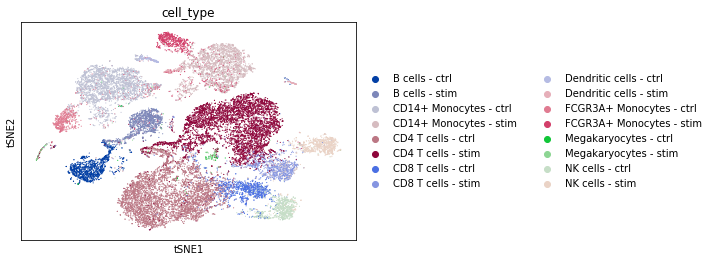

In [71]:
sc.pl.tsne(adata, color='cell_type')

In [72]:
print('Number of genes kept:', adata.shape[1])

Number of genes kept: 1654


### Total UMI count distribution for each cell type

In [72]:
total_umi_content = {}
for cell_type in adata.obs.cell_type.drop_duplicates().values:
    total_umi_content[cell_type] = adata.X[(adata.obs.cell_type == cell_type).values, :].sum(axis=1)

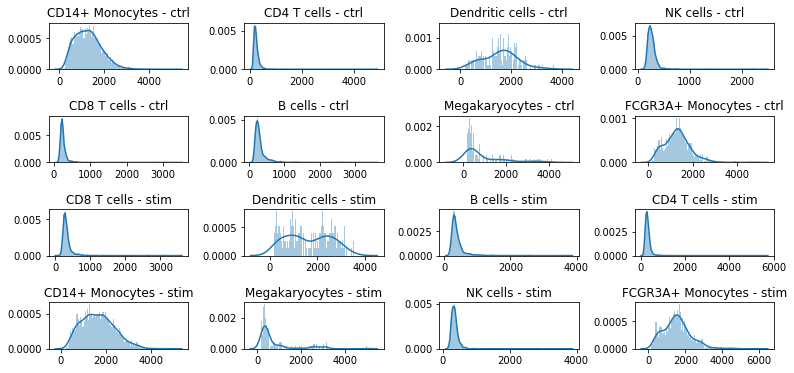

In [73]:
plt.figure(figsize=(13, 6))
plt.subplots_adjust(hspace=1, wspace=0.4)
idx = 1
for cell_type, total_umi_dist in total_umi_content.items():
    
    plt.subplot(4, 4, idx)
    sns.distplot(total_umi_dist, bins=100)
    plt.title(cell_type)
    idx +=1
# plt.subplot(4, 4, idx)
# sns.distplot(adata.X.sum(axis=1), bins=100);
# plt.title('All cells')

### Cell type marker genes

In [22]:
adata_ctrl = adata[adata.obs.stim == 'ctrl'].copy()

In [23]:
imp.reload(simplesc)
estimator = simplesc.SingleCellEstimator(
    adata_ctrl, 
    p=0.1, 
    num_permute=5,
    group_label='cell_type')

In [24]:
cell_type_stats = {}
for ct in adata_ctrl.obs.cell_type.drop_duplicates():
    
    print('Calculating stats for {}'.format(ct))
    
    estimator.compute_observed_statistics(group=ct)
    estimator.compute_observed_statistics(group=('-' + ct))
    
    estimator.compute_params(group=ct)
    estimator.compute_params(group=('-' + ct))

    estimator.compute_permuted_statistics(group=ct)
    estimator.compute_permuted_statistics(group=('-' + ct))
    
    t_stats, null_t_stats, pvals = estimator.differential_expression(ct, ('-' + ct), method='perm')
    cell_type_stats[ct] = {
        't_stat':t_stats,
        'null_t_stats':null_t_stats,
        'pvals': pvals
    }

Calculating stats for CD14+ Monocytes - ctrl
Calculating stats for CD4 T cells - ctrl
Calculating stats for Dendritic cells - ctrl
Calculating stats for NK cells - ctrl
Calculating stats for CD8 T cells - ctrl
Calculating stats for B cells - ctrl
Calculating stats for Megakaryocytes - ctrl
Calculating stats for FCGR3A+ Monocytes - ctrl


In [25]:
for ct in adata_ctrl.obs.cell_type.drop_duplicates():
    
    print(
        '{} markers:'.format(ct), 
        adata_ctrl.var.index[
            np.argsort(cell_type_stats[ct]['t_stat'])[::-1][np.where(np.isnan(cell_type_stats[ct]['t_stat']))[0].shape[0]:][:75]].tolist())
    fdr = np.full_like(cell_type_stats[ct]['t_stat'], np.nan)
    _, fdr[~np.isnan(cell_type_stats[ct]['pvals'])] = \
        fdrcorrection(cell_type_stats[ct]['pvals'][~np.isnan(cell_type_stats[ct]['pvals'])])
    print('Number of sig. at 0.01 FDR:', (fdr < 0.01).sum())
    print()

CD14+ Monocytes - ctrl markers: ['S100A8', 'S100A9', 'CLEC5A', 'CLEC4E', 'TYROBP', 'FTL', 'MGST1', 'CCL2', 'PLA2G7', 'S100A12', 'CD63', 'IL8', 'IER3', 'HPSE', 'LGALS1', 'ANPEP', 'C15orf48', 'FCER1G', 'VCAN', 'CTB-61M7.2', 'FCN1', 'LHFPL2', 'TREM1', 'FNDC3B', 'CD14', 'CTSB', 'THBS1', 'TGFBI', 'LACC1', 'ANXA5', 'SLC7A11', 'CD300E', 'OLR1', 'C5AR1', 'CYP27A1', 'TYMP', 'S100A10', 'GRN', 'PDLIM7', 'ENG', 'PID1', 'DUSP6', 'S100A4', 'GPR84', 'SERPINB2', 'S100A6', 'CCR1', 'MAFB', 'S100A11', 'GPX1', 'ATP6V0B', 'RAC1', 'NCF2', 'PLAUR', 'LILRB4', 'SPI1', 'RAB13', 'SPHK1', 'CD68', 'CCL7', 'MARCKSL1', 'C19orf59', 'TIMP1', 'LGALS2', 'PVRL2', 'SIRPA', 'ANXA2', 'KYNU', 'FTH1', 'FPR3', 'PSAP', 'CXCL2', 'FCGRT', 'LGALS3', 'LIMS1']
Number of sig. at 0.01 FDR: 1070

CD4 T cells - ctrl markers: ['LEF1', 'TSHZ2', 'PASK', 'LTB', 'ADTRP', 'AQP3', 'CD3E', 'TRAT1', 'CD27', 'IL7R', 'NELL2', 'CD3G', 'CD3D', 'TNFRSF25', 'LCK', 'TMEM204', 'AES', 'SPOCK2', 'CD6', 'KLF2', 'PIK3IP1', 'ICOS', 'TMEM173', 'CCNG1', 'SFXN1

### Mean-variance in normalized scRNA seq

In [73]:
adata_norm = adata.copy()

In [74]:
sc.pp.normalize_per_cell(adata_norm, counts_per_cell_after=1e4)


In [75]:
sc.pp.log1p(adata_norm)


In [76]:
sc.pp.scale(adata_norm, max_value=10)


In [101]:
raw_mean = adata.X.mean(axis=0)
raw_var = adata.X.mean(axis=0)

In [77]:
mean = adata_norm.X.mean(axis=0)
var = adata_norm.X.var(axis=0)

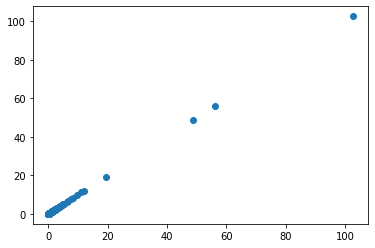

In [104]:
plt.scatter(raw_mean.A1, raw_var.A1)

(0.8, 1.05)

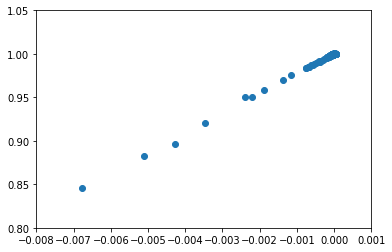

In [83]:
plt.scatter(mean, var)
plt.xlim(-0.008, 0.001)
plt.ylim(0.8, 1.05)

### Study the mean-variance relationship

In [84]:
imp.reload(simplesc)

<module 'simplesc' from '/Users/mincheolkim/Github/scrna-parameter-estimation/simplesc/simplesc.py'>

In [97]:
estimator = simplesc.SingleCellEstimator(
    adata, 
    p=0.01, 
    group_label='cell_type')

In [98]:
estimator.compute_observed_statistics(group='CD4 T cells - ctrl')
estimator.compute_observed_statistics(group='CD4 T cells - stim')

In [99]:
estimator.compute_params(group='CD4 T cells - ctrl')
estimator.compute_params(group='CD4 T cells - stim')

Text(0.5, 1.0, 'Mean - variance dependence')

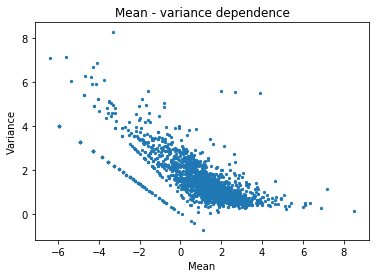

In [100]:
plt.scatter(
    estimator.estimated_mean['CD4 T cells - stim'],
    np.diag(estimator.estimated_cov['CD4 T cells - stim']),
    s=5
)
plt.xlabel('Mean');
plt.ylabel('Variance')
plt.title('Mean - variance dependence')

### Effect of interferon stimulation

In [144]:
imp.reload(simplesc)

<module 'simplesc' from '/Users/mincheolkim/Github/scrna-parameter-estimation/simplesc/simplesc.py'>

In [145]:
estimator = simplesc.SingleCellEstimator(
    adata, 
    p=0.05, 
    group_label='stim')

In [146]:
estimator.compute_observed_statistics(group='ctrl')
estimator.compute_observed_statistics(group='stim')

In [147]:
estimator.compute_params(group='ctrl')
estimator.compute_params(group='stim')

In [148]:
estimator.compute_permuted_statistics(group='ctrl')
estimator.compute_permuted_statistics(group='stim')


In [149]:
t_stats, null_t_stats, pvals = estimator.differential_expression('ctrl', 'stim', method='perm')


In [150]:
fdr = np.full_like(pvals, np.nan)
_, fdr[~np.isnan(pvals)] = fdrcorrection(pvals[~np.isnan(pvals)])


Text(0, 0.5, 'Count')

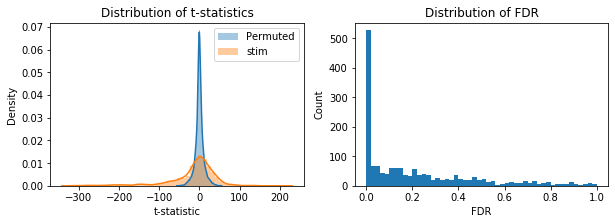

In [152]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1);
sns.distplot(null_t_stats[~np.isnan(null_t_stats)]);
sns.distplot(t_stats[~np.isnan(t_stats)]);
plt.legend(['Permuted','stim']);
plt.xlabel('t-statistic');
plt.ylabel('Density');
plt.title('Distribution of t-statistics')
plt.subplot(1, 2, 2);
plt.hist(fdr[~np.isnan(fdr)], bins=50);
plt.title('Distribution of FDR')
plt.xlabel('FDR');
plt.ylabel('Count')

In [153]:
print('Number of significant genes at 0.01 FDR:', (fdr < 0.01).sum())

Number of significant genes at 0.01 FDR: 453


In [154]:
print('Upregulated genes: ', adata.var.index[np.argsort(t_stats)[:50]].tolist())

Upregulated genes:  ['CXCL11', 'CCL8', 'IFIT1', 'IFIT3', 'HESX1', 'TGM1', 'IFIT2', 'CMPK2', 'ISG15', 'RSAD2', 'CXCL10', 'IFI44L', 'ISG20', 'HERC5', 'IL27', 'DEFB1', 'LY6E', 'OAS3', 'TNFSF10', 'NEXN', 'MX2', 'IL1RN', 'NUPR1', 'NT5C3A', 'OAS2', 'DDX58', 'MT2A', 'IFITM3', 'TRIM22', 'HERC6', 'APOBEC3A', 'ETV7', 'RTP4', 'APOBEC3B', 'IFI35', 'GMPR', 'CD38', 'DHX58', 'SAMD9', 'SAMD4A', 'IRG1', 'SAMD9L', 'IFIH1', 'IDO1', 'HES4', 'PNPT1', 'SERPING1', 'IFIT5', 'ZBP1', 'SPATS2L']


In [155]:
print('Downregulated genes: ', adata.var.index[np.argsort(t_stats)[::-1][:50]].tolist())

Downregulated genes:  ['CLEC5A', 'VCAN', 'C19orf59', 'PID1', 'OSM', 'IL1B', 'IL8', 'CTB-61M7.2', 'CD14', 'CD9', 'CYP27A1', 'IER3', 'PLXDC2', 'QSOX1', 'S100A8', 'CXCL1', 'PHLDA1', 'SLC11A1', 'THBS1', 'FOS', 'GLTP', 'GAPT', 'MARCKSL1', 'AMICA1', 'LTA4H', 'ENG', 'GLIPR1', 'QPCT', 'EIF3L', 'LRRC25', 'INSIG1', 'CD79B', 'HNMT', 'PPIF', 'PNP', 'G0S2', 'CLTB', 'C10orf54', 'ACTN1', 'SLC7A11', 'ID3', 'FERMT3', 'CD27', 'GNA15', 'EPB41L3', 'PDLIM7', 'CD82', 'PRDX5', 'AC093673.5', 'UCP2']


### Differential variance interferon stimulation

In [157]:
dv_t_stats, dv_null_t_stats, dv_pvals = estimator.differential_variance('ctrl', 'stim', method='perm', safe_estimation=False)


In [158]:
dv_fdr = np.full_like(dv_pvals, np.nan)
_, dv_fdr[~np.isnan(dv_pvals)] = fdrcorrection(pvals[~np.isnan(dv_pvals)])


In [160]:
print('Increased variance genes: ', adata.var.index[np.argsort(dv_t_stats)[:50]].tolist())



Increased variance genes:  ['DHRS7', 'CLTB', 'NUDT21', 'PPAPDC1B', 'COX5A', 'CCAR1', 'ALDH9A1', 'LARP7', 'DERL2', 'GLTP', 'ZRANB2', 'ZNF32', 'TM2D1', 'MMADHC', 'PRNP', 'TOX4', 'ATP6V1D', 'TUBB', 'HAX1', 'PPP1R8', 'EMC4', 'EIF3L', 'RWDD1', 'C9orf78', 'ACP1', 'GTF2B', 'PNMA1', 'CELF1', 'PTP4A2', 'PDCL3', 'RAB2A', 'DCAF13', 'SLA', 'HMGB2', 'RFWD2', 'MARCKSL1', 'MED6', 'ATP5C1', 'EBPL', 'PFDN2', 'IFRD2', 'EIF4A3', 'MGEA5', 'CLEC5A', 'SF3B5', 'CDK2AP2', 'PDCD5', 'TRA2B', 'EID1', 'CNPPD1']


In [161]:
print('Decreased variance genes: ', adata.var.index[np.argsort(dv_t_stats)[::-1][:50]].tolist())



Decreased variance genes:  ['ISG20', 'TRIM22', 'C19orf66', 'TREX1', 'SAMD9', 'IFI35', 'PHF11', 'LY6E', 'MX2', 'NT5C3A', 'IFIT5', 'XRN1', 'UQCRC2', 'PNPT1', 'GBP2', 'C5orf56', 'IFI44L', 'DDX60L', 'RTP4', 'PPM1K', 'DUSP11', 'PARP9', 'UGP2', 'KARS', 'OAS2', 'SAMD9L', 'CHST12', 'GBP4', 'DDX58', 'TMEM9B', 'HERC5', 'GSDMD', 'ELF1', 'HP1BP3', 'MT2A', 'DERL1', 'PARP12', 'TRIM38', 'TAPBP', 'HERC6', 'SAMHD1', 'SNX6', 'SPATS2L', 'IFIH1', 'OAS3', 'NUB1', 'OASL', 'TFG', 'ZNF281', 'B2M']


Text(0, 0.5, 'Count')

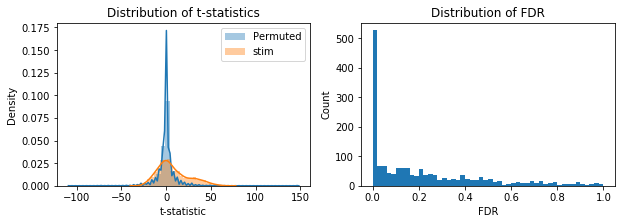

In [165]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1);
sns.distplot(dv_null_t_stats[~np.isnan(dv_null_t_stats)]);
sns.distplot(dv_t_stats[~np.isnan(dv_t_stats)]);
plt.legend(['Permuted','stim']);
plt.xlabel('t-statistic');
plt.ylabel('Density');
plt.title('Distribution of t-statistics')
plt.subplot(1, 2, 2);
plt.hist(dv_fdr[~np.isnan(dv_fdr)], bins=50);
plt.title('Distribution of FDR')
plt.xlabel('FDR');
plt.ylabel('Count')

In [188]:
dv_fdr[dv_t_stats < 0]

0.9996372430471583

In [236]:
idx = (dv_fdr < 0.1) & (dv_t_stats < 0)

In [237]:
idx.sum()

296

In [238]:
adata.var.index[idx].tolist()

['CTNNBIP1',
 'PGD',
 'TNFRSF1B',
 'ID3',
 'FUCA1',
 'STMN1',
 'FGR',
 'PPP1R8',
 'PTP4A2',
 'LCK',
 'MARCKSL1',
 'YARS',
 'C1orf122',
 'PABPC4',
 'ELOVL1',
 'JUN',
 'TM2D1',
 'GTF2B',
 'DNTTIP2',
 'DRAM2',
 'C1orf162',
 'ATP1A1',
 'CD58',
 'S100A9',
 'S100A12',
 'S100A8',
 'S100A6',
 'S100A4',
 'PBXIP1',
 'CCT3',
 'DUSP23',
 'ALDH9A1',
 'FASLG',
 'RFWD2',
 'QSOX1',
 'BTG2',
 'G0S2',
 'TRAF3IP3',
 'C1orf35',
 'ACP1',
 'ODC1',
 'QPCT',
 'CYP1B1',
 'GALM',
 'MCFD2',
 'CCDC88A',
 'WDR54',
 'PDCL3',
 'LIMS1',
 'IL1B',
 'HNMT',
 'SSB',
 'WIPF1',
 'SLC11A1',
 'CYP27A1',
 'TUBA4A',
 'PID1',
 'ITM2C',
 'PDE6D',
 'RAMP1',
 'GPR35',
 'PASK',
 'ARL8B',
 'SH3BP5',
 'GOLGA4',
 'SETD2',
 'IMPDH2',
 'GPX1',
 'IFRD2',
 'CYB561D2',
 'ATG3',
 'RNF7',
 'SMC4',
 'FGFBP2',
 'IGFBP7',
 'IL8',
 'CXCL1',
 'CXCL3',
 'CXCL2',
 'EREG',
 'HNRNPDL',
 'HSD17B11',
 'SLC7A11',
 'HMGB2',
 'GAPT',
 'HEXB',
 'VCAN',
 'TGFBI',
 'CD14',
 'YIPF5',
 'DUSP1',
 'CLTB',
 'PDLIM7',
 'TBC1D7',
 'TPMT',
 'TUBB',
 'IER3',
 'HLA-B'

In [170]:
idx.sum()

25

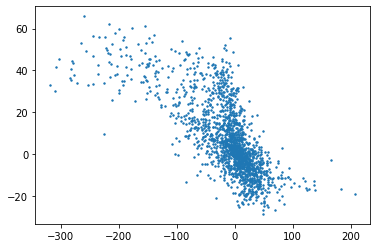

In [177]:
plt.scatter(t_stats, dv_t_stats, s=2);

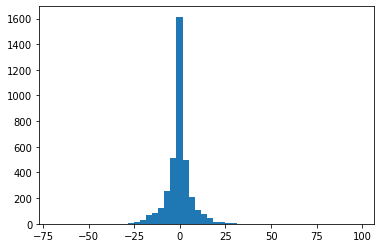

In [140]:
plt.hist(dv_null_t_stats, bins=50);

### Compute the null distribution

In [131]:
adata_ctrl.obs['fake_cell_type'] = np.random.permutation(adata_ctrl.obs['cell_type'])

In [132]:
imp.reload(simplesc)
estimator = simplesc.SingleCellEstimator(adata_ctrl, p=0.1, num_permute=3, group_label='fake_cell_type')

Text(0.5,1,'Mean - variance dependence')

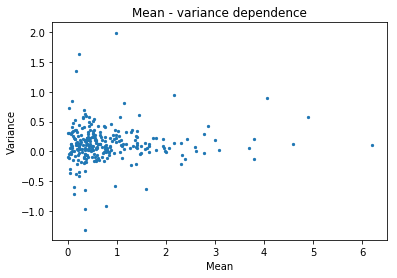

In [257]:
plt.scatter(
    estimator.estimated_mean['CD4 T cells - stim'][hxp],
    np.diag(estimator.estimated_cov['CD4 T cells - stim'][hxp]),
    s=5
)
plt.xlabel('Mean');
plt.ylabel('Variance')
plt.title('Mean - variance dependence')

In [133]:
estimator.compute_observed_statistics(group='CD4 T cells - ctrl')
estimator.compute_observed_statistics(group='CD14+ Monocytes - ctrl')

In [134]:
estimator.compute_params(group='CD4 T cells - ctrl')
estimator.compute_params(group='CD14+ Monocytes - ctrl')

In [135]:
estimator.compute_permuted_statistics(group='CD4 T cells - ctrl')
estimator.compute_permuted_statistics(group='CD14+ Monocytes - ctrl')


In [136]:
t_statistic, null_t_statistic, pvals = estimator.differential_expression('CD4 T cells - ctrl', 'CD14+ Monocytes - ctrl', method='perm')

Text(0.5,1,'Distribution of p-values for shuffled labels')

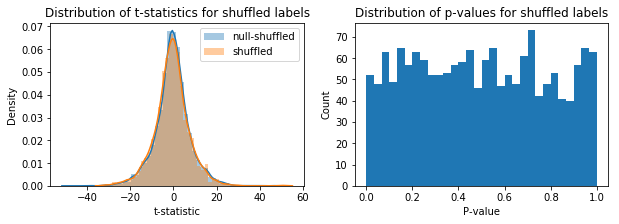

In [137]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1);
sns.distplot(null_t_statistic[~np.isnan(null_t_statistic)], bins=50);
sns.distplot(t_statistic[~np.isnan(t_statistic)], bins=50);
plt.title('Distribution of t-statistics for shuffled labels');
plt.ylabel('Density'); plt.xlabel('t-statistic');
plt.legend(['null-shuffled', 'shuffled']);
plt.subplot(1, 2, 2);
plt.hist(pvals[~np.isnan(pvals)], bins=30);
plt.ylabel('Count');plt.xlabel('P-value');
plt.title('Distribution of p-values for shuffled labels')